# 2. Building Models from Histogram Templates

**Pedagogical context.** This notebook covers the HistFactory model
specification, the standard template for binned statistical models at
the LHC. The material corresponds to Cowan's Lecture 13 (nuisance
parameters and systematic uncertainties) in its model-construction
aspects, and to Kyle Cranmer's "Thumbnail of LHC Statistical Procedures"
notebook in *Statistics and Data Science*.

The HistFactory model is built from four primitives: Parameter, Histogram,
Sample, and Channel. These compose into a Model that can be evaluated to
produce expected yields as a function of all its parameters. The
construction is purely declarative: you describe what the model looks
like, and the inference machinery consumes it downstream.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Parameter, Histogram, Sample, Channel, Model

## 2.1 Parameters

Every degree of freedom in the model is a Parameter. The signal strength
$\mu$ is the parameter of interest (POI); all others are nuisance
parameters. Each carries a name, a starting value, optional bounds, and
a flag for whether the minimiser should hold it fixed.

Names matter because they become the keys in the dictionary that flows
through the entire evaluation chain. Two modifiers sharing the same
parameter name will be driven by the same underlying degree of freedom,
which is how correlated systematics are expressed.

In [2]:
mu = Parameter("mu", value=1.0, bounds=(0.0, 10.0))
alpha = Parameter("jet_energy_scale", value=0.0, bounds=(-5.0, 5.0))
fixed = Parameter("lumi", value=1.0, bounds=(0.9, 1.1), fixed=True)

print(f"POI:      {mu}")
print(f"Nuisance: {alpha}")
print(f"Fixed:    {fixed}")

# Bounds are validated at construction
try:
    Parameter("bad", value=10.0, bounds=(0.0, 3.0))
except ValueError as e:
    print(f"\nBounds check: {e}")

POI:      Parameter(name='mu', value=1.0, bounds=(0.0, 10.0), fixed=False)
Nuisance: Parameter(name='jet_energy_scale', value=0.0, bounds=(-5.0, 5.0), fixed=False)
Fixed:    Parameter(name='lumi', value=1.0, bounds=(0.9, 1.1), fixed=True)

Bounds check: Parameter 'bad': value 10.0 is outside bounds (0.0, 3.0)


## 2.2 Histograms

The Histogram is an immutable container for binned data. It holds bin
contents and bin edges as numpy arrays, with validation at construction
to ensure consistency (edges must be monotonically increasing, and
there must be one more edge than bin). Arithmetic operations return
new histograms rather than modifying in place, which prevents
accidental corruption during model building.

In [3]:
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

# Create a simple histogram
h = Histogram([10, 25, 40, 25, 10], edges)
print(h)
print(f"Bin centres: {h.centres}")
print(f"Bin widths:  {h.widths}")
print(f"Total:       {h.total}")

# Arithmetic
h2 = h * 1.5
h3 = h + Histogram([1, 2, 3, 2, 1], edges)
print(f"\nScaled:  {h2.values}")
print(f"Summed:  {h3.values}")

# Integration over a sub-range
print(f"\nIntegrate [1.5, 3.5]: {h.integrate(1.5, 3.5):.1f}")

Histogram(nbins=5, range=(0, 5), total=110)
Bin centres: [0.5 1.5 2.5 3.5 4.5]
Bin widths:  [1. 1. 1. 1. 1.]
Total:       110.0

Scaled:  [15.  37.5 60.  37.5 15. ]
Summed:  [11. 27. 43. 27. 11.]

Integrate [1.5, 3.5]: 65.0


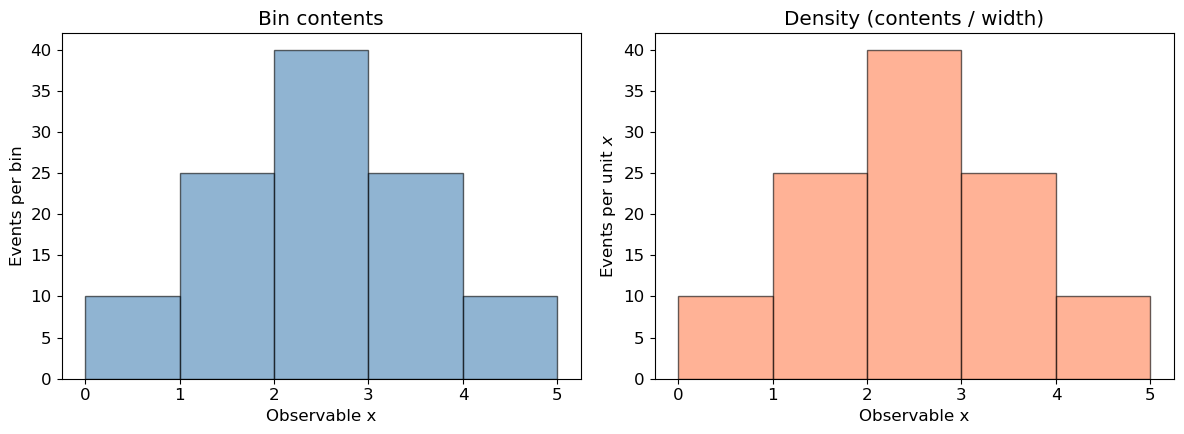

In [4]:
# Visualise
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

axes[0].bar(h.centres, h.values, width=h.widths, edgecolor="black",
            alpha=0.6, color="steelblue")
axes[0].set_xlabel("Observable x")
axes[0].set_ylabel("Events per bin")
axes[0].set_title("Bin contents")

axes[1].bar(h.centres, h.density, width=h.widths, edgecolor="black",
            alpha=0.6, color="coral")
axes[1].set_xlabel("Observable x")
axes[1].set_ylabel(r"Events per unit $x$")
axes[1].set_title("Density (contents / width)")
plt.tight_layout()
plt.show()

## 2.3 Samples and modifiers

A Sample wraps a nominal histogram template and attaches modifiers that
describe how the expected yield changes as a function of model parameters.
The simplest modifier is the normfactor, a free multiplicative scale.
When attached to the signal sample and named "mu", it becomes the
signal strength parameter of interest.

The `add_normfactor`, `add_normsys`, and `add_histosys` methods return
`self`, allowing fluent chaining.

In [5]:
# Templates for a Higgs-like search
sig_vals = np.array([1, 4, 10, 4, 1])
bkg_vals = np.array([30, 40, 35, 25, 20])

sig_template = Histogram(sig_vals, edges)
bkg_template = Histogram(bkg_vals, edges)

# Signal: free normalisation
signal = Sample("signal", sig_template)
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

# Background: 10% normalisation uncertainty
background = Sample("background", bkg_template)
background.add_normsys("bkg_norm", lo=0.9, hi=1.1)

print(f"Signal:     {signal}")
print(f"Background: {background}")
print(f"Signal parameters:     {[p.name for p in signal.parameters]}")
print(f"Background parameters: {[p.name for p in background.parameters]}")

Signal:     Sample('signal', nbins=5, modifiers=1)
Background: Sample('background', nbins=5, modifiers=1)
Signal parameters:     ['mu']
Background parameters: ['bkg_norm']


In [6]:
# Expected yields as a function of parameters
params_nominal = {"mu": 1.0, "bkg_norm": 0.0}
params_2x = {"mu": 2.0, "bkg_norm": 0.0}
params_bkg_up = {"mu": 1.0, "bkg_norm": 1.0}

print("Signal at mu=1:", signal.expected(params_nominal))
print("Signal at mu=2:", signal.expected(params_2x))
print("Background nominal:", background.expected(params_nominal))
print("Background at +1 sigma:", background.expected(params_bkg_up))

Signal at mu=1: [ 1.  4. 10.  4.  1.]
Signal at mu=2: [ 2.  8. 20.  8.  2.]
Background nominal: [30. 40. 35. 25. 20.]
Background at +1 sigma: [33.  44.  38.5 27.5 22. ]


## 2.4 Channels

A Channel represents one analysis region: a signal region, a control
region, or a validation region. It collects Samples (whose yields are
summed to produce the total prediction) and holds the observed data.

Data must be set before the channel can be added to a model. This is
a deliberate design choice: a model without data is meaningless for
inference, and catching the omission early avoids cryptic errors
during fitting.

In [7]:
# Pseudo-data: inject signal at mu=1.5
np.random.seed(7)
true_params = {"mu": 1.5, "bkg_norm": 0.0}
expected_yields = signal.expected(true_params) + background.expected(true_params)
data = np.random.poisson(expected_yields.astype(int))

sr = Channel("signal_region")
sr.add_sample(signal)
sr.add_sample(background)
sr.set_data(data)

print(sr)
print(f"Expected (nominal): {sr.expected(params_nominal)}")
print(f"Observed data:      {data}")

Channel('signal_region', samples=2, nbins=5, data=yes)
Expected (nominal): [31. 44. 45. 29. 21.]
Observed data:      [21 45 50 27 23]


## 2.5 Multi-channel models

The power of the HistFactory approach becomes clear with multiple
channels. A control region that is rich in background events constrains
the background nuisance parameter, which tightens the measurement in the
signal region. This is the "simultaneous fit" that every LHC analysis
uses.

When two channels share a nuisance parameter name, Histimator
automatically treats them as the same degree of freedom. The model
merges parameters by name and builds a single concatenated likelihood.

In [8]:
# Add a background-enriched control region
cr_bkg_vals = np.array([200, 250, 220, 180, 150])
cr_sig_vals = np.array([0.5, 1, 2, 1, 0.5])  # negligible signal

cr_sig = Sample("signal", Histogram(cr_sig_vals, edges))
cr_sig.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

cr_bkg = Sample("background", Histogram(cr_bkg_vals, edges))
cr_bkg.add_normsys("bkg_norm", lo=0.9, hi=1.1)  # same name = correlated

# Control region data: background-only
np.random.seed(8)
cr_data = np.random.poisson(cr_bkg_vals)

cr = Channel("control_region")
cr.add_sample(cr_sig)
cr.add_sample(cr_bkg)
cr.set_data(cr_data)

# Build the combined model
combined = Model("combined_search")
combined.add_channel(sr)
combined.add_channel(cr)

print(combined)
print(f"Total bins: {combined.total_nbins}")
print(f"Parameters: {combined.parameter_names}")
print(f"\nNote: 'bkg_norm' appears once despite being in both channels.")

Model('combined_search', channels=['signal_region', 'control_region'], parameters=['mu', 'bkg_norm'])
Total bins: 10
Parameters: ['mu', 'bkg_norm']

Note: 'bkg_norm' appears once despite being in both channels.


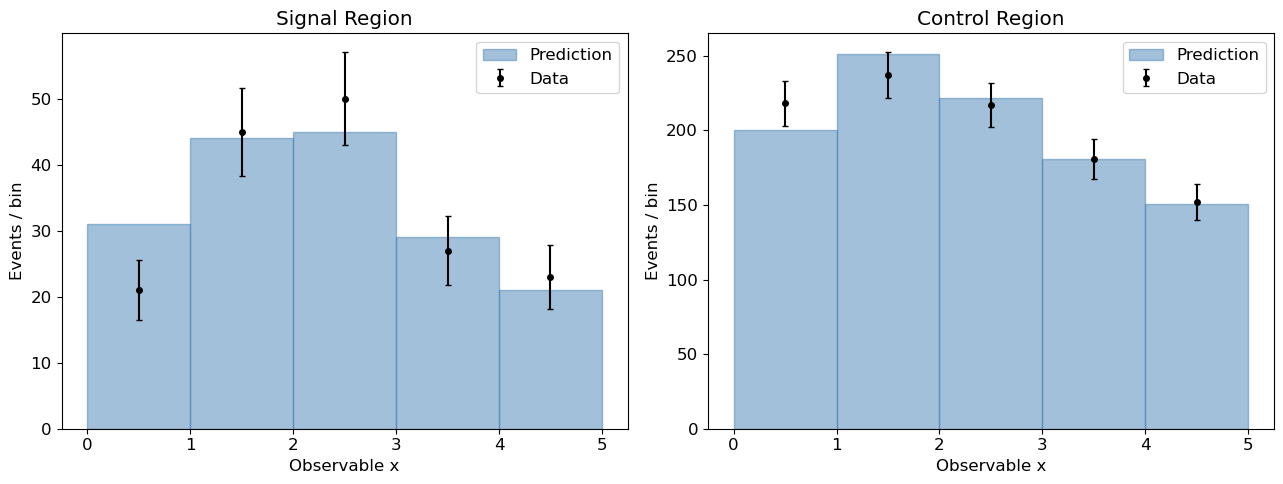

In [9]:
# Visualise both channels
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, ch_obj, title in [
    (axes[0], sr, "Signal Region"),
    (axes[1], cr, "Control Region"),
]:
    nom = ch_obj.expected(params_nominal)
    ax.bar(edges[:-1], nom, width=np.diff(edges), align="edge",
           alpha=0.5, color="steelblue", edgecolor="steelblue", label="Prediction")
    ax.errorbar(Histogram(ch_obj.data.values, edges).centres,
                ch_obj.data.values,
                yerr=np.sqrt(np.maximum(ch_obj.data.values, 1)),
                fmt="ko", ms=4, capsize=2, label="Data")
    ax.set_xlabel("Observable x")
    ax.set_ylabel("Events / bin")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

## Exercises

**Exercise 2.1.** Create a three-channel model: a signal region with
5 bins, a $t\bar{t}$ control region with 3 bins, and a $W$+jets control
region with 3 bins. The signal region should have signal, $t\bar{t}$,
and $W$+jets samples. Each control region should have only its
corresponding background (no signal contamination). Attach a
normalisation systematic to each background sample, using the same
parameter name across the signal and control regions to correlate them.
Print the model and verify that the parameter count is what you expect.

**Exercise 2.2.** For the single-channel model from Section 2.4,
compute the total expected yield as a function of $\mu$ from 0 to 5
in steps of 0.5. Plot expected vs $\mu$ for each bin separately,
confirming that each bin scales linearly with $\mu$.

**Exercise 2.3.** The `Histogram.from_numpy` class method creates a
Histogram from the output of `numpy.histogram`. Generate 10,000 random
samples from a Gaussian with mean 2.5 and sigma 0.8, histogram them
into 10 bins between 0 and 5, and create a Histogram. Verify that the
total matches the number of samples.

## References

K. Cranmer, G. Lewis, L. Moneta, A. Shibata, W. Verkerke.
"HistFactory: A tool for creating statistical models for use with
RooFit and RooStats." CERN-OPEN-2012-016 (2012).

G. Cowan, *Statistical Data Analysis*, Lecture 13: Nuisance parameters
and systematic uncertainties.

K. Cranmer, "Thumbnail of LHC Statistical Procedures", in *Statistics
and Data Science*, NYU.